In [24]:
import os
import cv2
import numpy as np
import albumentations as A

# Input directories
image_dir = r"C:\Users\wasif\Desktop\Annotated Images\images"
mask_dir = r"C:\Users\wasif\Desktop\Annotated Images\masks"

# Output directories
aug_img_dir = r"C:\Users\wasif\Desktop\Annotated Images\Augmented\images"
aug_mask_dir = r"C:\Users\wasif\Desktop\Annotated Images\Augmented\masks"
os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_mask_dir, exist_ok=True)

# Augmentation pipeline (no resize!)
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, border_mode=cv2.BORDER_REFLECT_101, p=0.4),
    A.RandomBrightnessContrast(p=0.2)
])

# Number of augmented versions per file
N_AUGS = 10

# Loop through each RGB image
for filename in os.listdir(image_dir):
    if filename.endswith("_RGB.png"):
        base_id = filename.replace("_RGB.png", "")
        img_path = os.path.join(image_dir, filename)
        mask_filename = f"{base_id}_annotated.png"
        mask_path = os.path.join(mask_dir, mask_filename)

        if not os.path.exists(mask_path):
            print(f":( Mask not found for {filename}, skipping.")
            continue

        # Read image and mask
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Validate dimensions match
        if image.shape[:2] != mask.shape:
            print(f":( Dimension mismatch for {filename}, skipping.")
            continue

        for i in range(N_AUGS):
            augmented = transform(image=image, mask=mask)

            if augmented["mask"] is None:
                print(f"⚠️ Skipping {filename} aug {i}: mask is None")
                continue

            aug_img = augmented["image"]
            aug_mask = augmented["mask"]

            # Ensure mask stays binary
            aug_mask_bin = (aug_mask > 127).astype(np.uint8) * 255

            out_img_path = os.path.join(aug_img_dir, f"{base_id}_aug{i}.png")
            out_mask_path = os.path.join(aug_mask_dir, f"{base_id}_aug{i}.png")

            cv2.imwrite(out_img_path, aug_img)
            cv2.imwrite(out_mask_path, aug_mask_bin)

            print(f"✅ Saved: {out_img_path} & {out_mask_path}")

print(":) All full-size augmentations completed.")


✅ Saved: C:\Users\wasif\Desktop\Annotated Images\Augmented\images\Image_10_aug0.png & C:\Users\wasif\Desktop\Annotated Images\Augmented\masks\Image_10_aug0.png
✅ Saved: C:\Users\wasif\Desktop\Annotated Images\Augmented\images\Image_10_aug1.png & C:\Users\wasif\Desktop\Annotated Images\Augmented\masks\Image_10_aug1.png
✅ Saved: C:\Users\wasif\Desktop\Annotated Images\Augmented\images\Image_10_aug2.png & C:\Users\wasif\Desktop\Annotated Images\Augmented\masks\Image_10_aug2.png
✅ Saved: C:\Users\wasif\Desktop\Annotated Images\Augmented\images\Image_10_aug3.png & C:\Users\wasif\Desktop\Annotated Images\Augmented\masks\Image_10_aug3.png
✅ Saved: C:\Users\wasif\Desktop\Annotated Images\Augmented\images\Image_10_aug4.png & C:\Users\wasif\Desktop\Annotated Images\Augmented\masks\Image_10_aug4.png
✅ Saved: C:\Users\wasif\Desktop\Annotated Images\Augmented\images\Image_10_aug5.png & C:\Users\wasif\Desktop\Annotated Images\Augmented\masks\Image_10_aug5.png
✅ Saved: C:\Users\wasif\Desktop\Annotate

In [4]:
import os
from PIL import Image
import numpy as np

# Parameters
CROP_SIZE = 256
STRIDE = 256
MIN_FOREGROUND_RATIO = 0.03  # At least 3% of pixels are foreground
MIN_VARIANCE = 5            

# Paths
INPUT_IMAGE_DIR = r"C:\Users\wasif\Desktop\Annotated Images\Augmented\images"
INPUT_MASK_DIR = r"C:\Users\wasif\Desktop\Annotated Images\Augmented\masks"
OUTPUT_IMAGE_DIR = r"C:\Users\wasif\Desktop\Cropped\images"
OUTPUT_MASK_DIR = r"C:\Users\wasif\Desktop\Cropped\masks"

os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

## 🖼️ Step 2: Load and Process Each Annotated Scene

We'll loop through all 8000x8000 PNG images and their corresponding masks.
For each scene:
- Slide a 256×256 window across the image
- Extract the corresponding region from the mask
- Save crops that contain meaningful annotation (i.e., not empty)


In [5]:
crop_counter = 0

# Loop through each image
for filename in os.listdir(INPUT_IMAGE_DIR):
    if filename.endswith('.png'):
        print(f"📂 Processing: {filename}")
        
        image_path = os.path.join(INPUT_IMAGE_DIR, filename)
        mask_path = os.path.join(INPUT_MASK_DIR, filename)

        if not os.path.exists(mask_path):
            print(f"❌ Mask not found for {filename}, skipping.")
            continue

        # Load image and mask
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        image_np = np.array(image)
        mask_np = np.array(mask)
        h, w = mask_np.shape

        for y in range(0, h - CROP_SIZE + 1, STRIDE):
            for x in range(0, w - CROP_SIZE + 1, STRIDE):
                img_crop = image_np[y:y+CROP_SIZE, x:x+CROP_SIZE]
                mask_crop = mask_np[y:y+CROP_SIZE, x:x+CROP_SIZE]

                # Foreground content check
                fg_ratio = np.sum(mask_crop > 0) / (CROP_SIZE * CROP_SIZE)
                if fg_ratio < MIN_FOREGROUND_RATIO:
                    continue  # Skip low-content crops

                # Optional: RGB variance check (filters out blank/uniform regions)
                if np.var(img_crop) < MIN_VARIANCE:
                    continue

                # Save useful crop
                crop_img = Image.fromarray(img_crop)
                crop_mask = Image.fromarray(mask_crop)

                crop_name = f"crop_{crop_counter:05d}.png"
                crop_img.save(os.path.join(OUTPUT_IMAGE_DIR, crop_name))
                crop_mask.save(os.path.join(OUTPUT_MASK_DIR, crop_name))
                crop_counter += 1

print(f"\n✅ Done! Total image/mask pairs saved: {crop_counter}")

📂 Processing: Image_10_aug0.png
📂 Processing: Image_10_aug1.png
📂 Processing: Image_10_aug2.png
📂 Processing: Image_10_aug3.png
📂 Processing: Image_10_aug4.png
📂 Processing: Image_10_aug5.png
📂 Processing: Image_10_aug6.png
📂 Processing: Image_10_aug7.png
📂 Processing: Image_10_aug8.png
📂 Processing: Image_10_aug9.png
📂 Processing: Image_14_aug0.png
📂 Processing: Image_14_aug1.png
📂 Processing: Image_14_aug2.png
📂 Processing: Image_14_aug3.png
📂 Processing: Image_14_aug4.png
📂 Processing: Image_14_aug5.png
📂 Processing: Image_14_aug6.png
📂 Processing: Image_14_aug7.png
📂 Processing: Image_14_aug8.png
📂 Processing: Image_14_aug9.png
📂 Processing: Image_15_aug0.png
📂 Processing: Image_15_aug1.png
📂 Processing: Image_15_aug2.png
📂 Processing: Image_15_aug3.png
📂 Processing: Image_15_aug4.png
📂 Processing: Image_15_aug5.png
📂 Processing: Image_15_aug6.png
📂 Processing: Image_15_aug7.png
📂 Processing: Image_15_aug8.png
📂 Processing: Image_15_aug9.png
📂 Processing: Image_1_aug0.png
📂 Process

In [22]:
from PIL import Image
import os

crop_dir = r'C:\Users\wasif\Desktop\crops\images'  # or wherever your crops are saved

for fname in os.listdir(crop_dir):
    if fname.endswith('.png'):
        img = Image.open(os.path.join(crop_dir, fname))
        if img.size != (256, 256):
            print(f"❌ {fname} is {img.size} — not 256x256")
        else:
            print(f"✅ {fname} is 256x256")
        break  # remove this break to scan all files


✅ crop_00000.png is 256x256


C:\Users\wasif\AppData\Local\Temp\2\ipykernel_7372\3112794088.py:24: RuntimeWarning: overflow encountered in scalar add
  total_fg_pixels += fg_pixels


🧾 Dataset Summary:
Total Masks: 79558
Foreground: 55.60%
Background: 44.40%


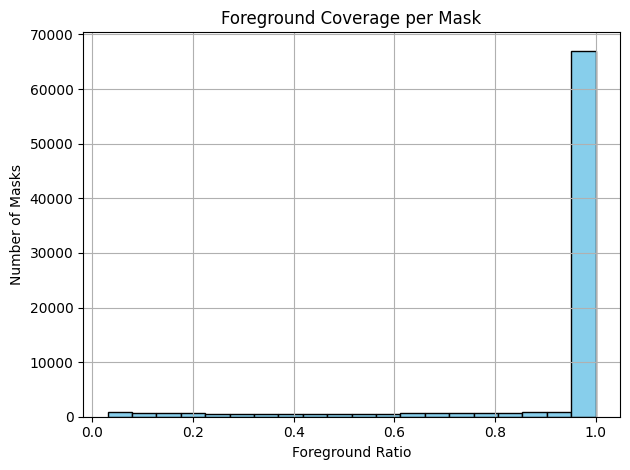

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

mask_dir = r"C:\Users\wasif\Desktop\Cropped\masks"

total_fg_pixels = 0
total_bg_pixels = 0
coverage_ratios = []

for filename in os.listdir(mask_dir):
    if filename.endswith(".png"):
        mask_path = os.path.join(mask_dir, filename)
        mask = Image.open(mask_path).convert("L")
        mask_np = np.array(mask)

        # Binarize if needed (assumes 0 and 255)
        binary_mask = (mask_np > 127).astype(np.uint8)

        fg_pixels = np.sum(binary_mask == 1)
        bg_pixels = np.sum(binary_mask == 0)
        
        total_fg_pixels += fg_pixels
        total_bg_pixels += bg_pixels

        coverage_ratio = fg_pixels / (fg_pixels + bg_pixels)
        coverage_ratios.append(coverage_ratio)

# Summary
total_pixels = total_fg_pixels + total_bg_pixels
fg_ratio = total_fg_pixels / total_pixels
bg_ratio = total_bg_pixels / total_pixels

print(f"🧾 Dataset Summary:")
print(f"Total Masks: {len(coverage_ratios)}")
print(f"Foreground: {fg_ratio * 100:.2f}%")
print(f"Background: {bg_ratio * 100:.2f}%")

# Optional: histogram of per-image coverage
plt.hist(coverage_ratios, bins=20, color='skyblue', edgecolor='black')
plt.title("Foreground Coverage per Mask")
plt.xlabel("Foreground Ratio")
plt.ylabel("Number of Masks")
plt.grid(True)
plt.tight_layout()
plt.show()
